## Session 0.0: import dependancies

In [ ]:
## import libraries for the analysis
import os,sys,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
##import modules from other folders
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt
from data_cleaning import preprocess_fictrac_data
sys.path.insert(0, str(parent_dir) + "\\bonfic")
from analyse_stimulus_evoked_response import main

### Session 0.1: Load analysis methods in python dictionary form

In [ ]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
sheet_name="Zball"
Datasets="Z:/DATA/experiment_trackball_Optomotor"
thisDataset = f"{Datasets}/{sheet_name}"

### Session 0.2: check methods to use and whether some methods should be updated

### Session 0.3: Load animal directory as a list

In [ ]:
## this cell searches for a folder with a specified experiment_name under the dataset path and list up all the csv file in that folder.
## In this project, we usually have one csv file in that folder so there is no confusion
dir_list = []
file_type=".dat"
for root, dirs, files in os.walk(thisDataset):
    if analysis_methods.get("experiment_name") in root.split(
        os.path.sep
    ):  ## add this condition to avoid data from other experiments
        for folder in dirs:
            if folder.startswith("session"):
                folder_path=os.path.join(root,folder)
                if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                    dir_list.append(folder_path.replace("\\", "/"))


print(f"these directories are found {dir_list}")

In [ ]:
def find_session_folders(base_directory, file_type, paradigm_name):
    session_folders = []

    for root, dirs, files in os.walk(base_directory):
        # Check if the target folder (e.g., 'apple') is in the root path and the paradigm name is in the root path
        if paradigm_name in root.split(os.path.sep):
            for folder in dirs:
                # Check if the folder name starts with 'session'
                if folder.startswith("session"):
                    folder_path = os.path.join(root, folder)
                    # Check if the folder contains at least one file with the specified file type
                    if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                        session_folders.append(folder_path)

    return session_folders



In [ ]:
base_directory = thisDataset
file_type = ".dat"
paradigm_name = analysis_methods.get("experiment_name")

session_folders = find_session_folders(base_directory, file_type, paradigm_name)

print(f"These directories are found: {session_folders}")

## Session 1.0: Create fictrac curated dataset based on the list of directories

In [ ]:
# because the import does not update the new version of python.
# Need to restart kernel 
for this_dir in dir_list:
    if "database_curated.pickle" in os.listdir(this_dir):
        print(f"curated fictrac data found in {this_dir}. Skip this file")
        continue
    else:
        print(f"no curated fictrac data in {this_dir}. Create curated file")
        preprocess_fictrac_data(this_dir,analysis_methods)

### Session 1.5: load particular animals into directory list for further analysis

In [ ]:
# Define the path to your Excel file
dir_list = []
file_type=".pickle"
using_google_sheet=True
sheet_name = "VCCball"
experiment_name=analysis_methods.get("experiment_name")
if analysis_methods.get("load_experiment_condition_from_database") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file

        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
        animal_of_interest=select_animals_gpt(df,"Experimenter","NS")
        #print(animal_of_interest)
    else:
        animal_of_interest=df
    ID_array=animal_of_interest["ID"].values
    dir_list = [
    root.replace("\\", "/")
    for root, dirs, files in os.walk(thisDataset)
    if any(ID in root for ID in ID_array)
    and experiment_name in root.split(os.path.sep)
    and any(name.endswith(file_type) for name in files)


    
]
else:
    ## this cell searches for a folder with a specified experiment_name under the dataset path and list up all the hdf5 file in that folder.
    ## However,some changes need to be made once we do sleap or deeplabcut where there are more than one H5 file generated
    for root, dirs, files in os.walk(thisDataset):
        if analysis_methods.get("experiment_name") in root.split(os.path.sep):## add this condition to avoid data from other experiments
            for folder in dirs:
                if folder.startswith("session"):
                    folder_path = os.path.join(root, folder)
                    # Check if the folder contains at least one file with the specified file type
                    if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                        session_folders.append(folder_path)

## Session 2.1: analyse individual animal's optomotor response with curated fictrac tracking

In [ ]:
# because the import does not update the new version of python.
# Need to restart kernel 
output0_across_exp=[]
output1_across_exp=[]
output2_across_exp=[]
output3_across_exp=[]
output4_across_exp=[]
for this_dir in dir_list[23:]:
    if "archive" in this_dir:
        print(f"skip archive folder for {this_dir}")
        continue
    summary,speed,rotation,travel_distance_whole_session=main(this_dir,analysis_methods)
    output0_across_exp.append(summary)
    output1_across_exp.append(speed)
    output2_across_exp.append(rotation)
    output3_across_exp.append(travel_distance_whole_session)
    output4_across_exp.append(this_dir)

### Session 2.2: Analyse individual animal's optomotor response with the multi-engines module

In [ ]:
##this cell start the multi-engines. Make sure to run only once
import time
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    return cluster_id

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

In [ ]:
##input cluster_id from previous cell
rc = ipp.Client(cluster_id=cluster_neuropc)

# Create a DirectView for parallel execution
dview = rc.direct_view()

# Define a function for parallel processing
def process_directory(this_dir, analysis_methods):
    from analyse_stimulus_evoked_response import main
    # Check if the H5 file (curated dataset) exists
    summary,speed,rotation = main(this_dir, analysis_methods)
    return (summary,speed,rotation)

# Define analysis_methods

# Use parallel execution to process directories
results = dview.map_sync(process_directory, dir_list, [analysis_methods] * len(dir_list))

# Initialize result lists
output0_across_exp=[]
output1_across_exp=[]
output2_across_exp=[]

# Collect and organize results
for result in results:
    if result is not None:
        summary,speed,rotation = result
        output0_across_exp.append(summary)
        output1_across_exp.append(speed)
        output2_across_exp.append(rotation)

# Now, you have the results collected in the respective lists

In [ ]:
rc.shutdown()

### Session 2.3: plot average behavioural data

In [ ]:
visual_paradigm_name= analysis_methods.get("experiment_name")
colormap = np.array(analysis_methods.get("graph_colour_code"))
fig2, (ax3, ax4) = plt.subplots(
    nrows=1, ncols=2, figsize=(18, 7), tight_layout=True
)
for i in range(len(output0_across_exp)):
    this_animal = output0_across_exp[i]
    tmp=this_animal.groupby("stim_type").count()
    follow_count_coherence = tmp.index.values
    for j in range(len(this_animal.groupby("stim_type"))):
        this_coherence=follow_count_coherence[j]
        this_response = this_animal.loc[
            this_animal["stim_type"] == this_coherence, "opto_index"
        ].values
        # this_coherence = x_axis_value_running_trials[i]
        mean_response = np.mean(this_response, axis=0)
        sem_response = np.std(this_response, axis=0, ddof=1) / np.sqrt(
            this_response.shape[0]
        )
        ax3.errorbar(
            this_coherence,
            mean_response,
            yerr=sem_response,
            c=colormap[5],
            fmt="o",
            elinewidth=2,
            capsize=3,
        )
    ax3.set_ylim(-1, 1)
    ax3.set(
        yticks=[-1, 0, 1],
        ylabel="Optomotor Index",
        xlabel=visual_paradigm_name,)
    # ax4.scatter(follow_count_coherence, follow_count, c=colormap[0], marker="o")
    # ax4.set_ylim(0, 15)
    # ax4.set(
    #     yticks=[0, 15],
    #     ylabel="Follow response (count)",
    #     xticks=[100, 50, 0, -50, -100],
    #     xlabel="Coherence level (%)",
    # )
    ##following one dot (dot lifetime)
    ##memory part (30s)
    ##interval: rondot
    ##continous

## Session 3: load ephys data

#### Session 3.0: import packages for analysis

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import time, os, json, warnings
#import spikeinterface.full as si
import spikeinterface.core as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.sorters as ss
import spikeinterface.qualitymetrics as sq
import spikeinterface.exporters as sep
from raw2si import *
from spike_curation import *

### Session 3.1: create pre-processed dataset and apply an automatic sorter to ephys data

In [ ]:
##specify an animal root folder to speed up the process because there are a lot of subfolders to look for
dir_list = []
thisDataset=r"Y:\GN25037"
for root, dirs, files in os.walk(thisDataset):
    for folder in dirs:
        if folder.startswith("Record"):
            dir_list.append(Path(root))

In [ ]:
dir_listH10_rev=['Y:/GN25027/250726/coherence/session1/2025-07-26_20-11-04','Y:/GN25027/250726/looming/session1/2025-07-26_22-04-13','Y:/GN25028/250727/coherence/session1/2025-07-27_19-24-54','Y:/GN25028/250727/looming/session1/2025-07-27_20-46-29','Y:/GN25029/250729/coherence/session1/2025-07-29_20-16-03','Y:/GN25029/250729/gratings/session1/2025-07-29_19-53-04','Y:/GN25029/250729/looming/session1/2025-07-29_15-22-54','Y:/GN25029/250729/looming/session2/2025-07-29_17-35-20','Y:/GN25029/250729/looming/session3/2025-07-29_18-35-50','Y:/GN25029/250729/sweeping/session1/2025-07-29_16-34-15','Y:/GN25030/250802/looming/session1/2025-08-02_19-34-32','Y:/GN25030/250802/sweeping/session1/2025-08-02_21-13-32','Y:/GN25031/250803/looming/session1/2025-08-03_17-52-45','Y:/GN25031/250803/sweeping/session1/2025-08-03_19-15-57','Y:/GN25032/250807/gratings/session1/2025-08-07_23-44-57','Y:/GN25032/250807/looming/session1/2025-08-07_19-34-42','Y:/GN25032/250807/looming/session2/2025-08-07_22-06-12','Y:/GN25032/250807/looming/session3/2025-08-08_00-13-39','Y:/GN25032/250807/looming/session4/2025-08-08_01-19-05','Y:/GN25032/250807/sweeping/session1/2025-08-07_20-58-03']

In [ ]:
json_file = "./analysis_methods_dictionary.json"

if isinstance(json_file, dict):
    analysis_methods = json_file
else:
    with open(json_file, "r") as f:
        print(f"load analysis methods from file {json_file}")
        analysis_methods = json.loads(f.read())

In [ ]:
#analysis_methods.update({"save_prepocessed_file": True,"load_prepocessed_file": False,"save_sorting_file":True,"load_sorting_file":False,"remove_dead_channels":False,"analyse_good_channels_only":False})
for oe_folder in dir_listH10_rev[10:14]:
    if type(oe_folder)==str:
        oe_folder=Path(oe_folder)
    print(f"processing {oe_folder}")
    raw2si(oe_folder, analysis_methods)

In [ ]:
phy_file_pattern="params*"
overwrite_existing_phy=analysis_methods.get("overwrite_existing_phy")
#analysis_methods.update({"save_prepocessed_file": False,"load_prepocessed_file": True,"save_sorting_file":False,"load_sorting_file":True})
for oe_folder in dir_list:
    if any(Path(oe_folder).glob(phy_file_pattern)) and overwrite_existing_phy==False:
        continue
    else:
        sorting_analyzer=si2phy(oe_folder, analysis_methods)

#### Session 3.2: analyse single file with multiple sorters

In [ ]:
oe_folder=r'Y:\GN25037\250922\looming\session2\2025-09-22_15-59-41'
sorter_list=["kilosort4","spykingcircus2"]
for this_sorter in sorter_list:
    analysis_methods.update({'sorter_name': this_sorter})
    raw2si(oe_folder, analysis_methods)
    _=si2phy(oe_folder, analysis_methods)

## Session 4: visualise the result

In [ ]:
this_sorter="kilosort4"
if analysis_methods.get("include_MUA") == True:
    cluster_group_interest = ["noise"]
else:
    cluster_group_interest = ["noise", "mua"]
sorter_suffix = generate_sorter_suffix(this_sorter)
phy_folder_name = "phy" + sorter_suffix
analyser_folder_name = "analyser" + sorter_suffix
sorting_spikes = se.read_phy(
    oe_folder / phy_folder_name, exclude_cluster_groups=cluster_group_interest
)
unit_labels = sorting_spikes.get_property("quality")
recording_saved = get_preprocessed_recording(oe_folder,analysis_methods)
sorting_analyzer = si.create_sorting_analyzer(
    sorting=sorting_spikes,
    recording=recording_saved,
    sparse=True,  # default
    format="memory",  # default
)
analysis_methods.update({"load_curated_spikes": False})
analysis_methods.update({"save_prepocessed_file": False,"load_prepocessed_file": True,"save_sorting_file":False,"load_sorting_file":True})

In [ ]:
calculate_analyzer_extension(sorting_analyzer)

In [ ]:
from spikeinterface_gui import run_mainwindow
run_mainwindow(sorting_analyzer)

In [ ]:
run_mainwindow(sorting_analyzer)
# %gui qt
4# sw.plot_sorting_summary(sorting_analyzer, backend="spikeinterface_gui")

### Session 3.2: spike sorting curation and create spike analyser as a database

In [ ]:
def that_ephys_folder_not_exist(base_directory,pattern):
    for item in os.listdir(base_directory):
        item_path = os.path.join(base_directory, item)
        if os.path.isdir(item_path) and item.startswith(pattern):
            return False
    return True
for this_dir in dir_list:
    if that_ephys_folder_not_exist(this_dir,"phy"):
        print(f"The directory '{this_dir}' does not contain any folders starting with phy. That means the manual curation process is not done")
        #spike_curation(this_dir,analysis_methods)
    elif that_ephys_folder_not_exist(this_dir,"analyser"):
        print(f"The directory '{this_dir}' does not contain any folders starting with analyser. That means the curated data has not been process with anlayser yet")
    else:
        print(f"The directory '{this_dir}' have both folders. Hence it is ready to move on to the next session.")
        continue
        #decode_spikes(this_dir,analysis_methods)


### Session 3.3: Sync ephys data with other datasets so that we can plot spike rate in response to the onset of certain events

## Session 4: Validate the result of automatic sorters

#### Session 4.1

In [3]:
this_dir = r"Y:\GN25037\250922\looming\session2\2025-09-22_15-59-41"
json_file = "./analysis_methods_dictionary.json"
oe_folder = Path(this_dir)
if isinstance(json_file, dict):
    analysis_methods = json_file
else:
    with open(json_file, "r") as f:
        print(f"load analysis methods from file {json_file}")
        analysis_methods = json.loads(f.read())
this_experimenter = analysis_methods.get("experimenter")
if analysis_methods.get("include_MUA") == True:
    cluster_group_interest = ["noise"]
else:
    cluster_group_interest = ["noise", "mua"]

load analysis methods from file ./analysis_methods_dictionary.json


In [4]:
sorter_list=["kilosort4","spykingcircus2"]
unit_list=[]
analyser_list=[]
for this_sorter in sorter_list:
    sorter_suffix = generate_sorter_suffix(this_sorter)
    phy_folder_name = "phy" + sorter_suffix
    analyser_folder_name = "analyser" + sorter_suffix
    analyser_list.append(analyser_folder_name)
    unit_list.append(se.read_phy(
        oe_folder / phy_folder_name, exclude_cluster_groups=cluster_group_interest
    ))

In [5]:
import spikeinterface.comparison as scom

In [9]:
import spikeinterface.widgets as sw

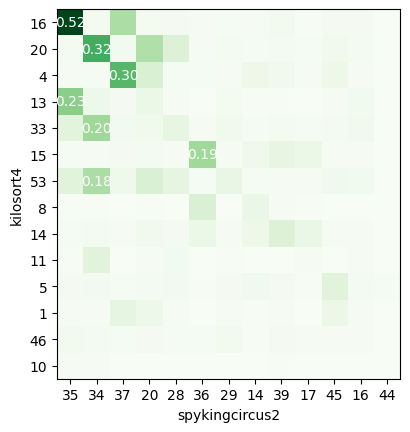

In [10]:
comp2sorters= scom.compare_two_sorters(unit_list[0], unit_list[1], sorter_list[0], sorter_list[1])
w = sw.plot_agreement_matrix(comp2sorters)

Multicomparison step 1: pairwise comparison
Multicomparison step 2: make graph
Multicomparison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


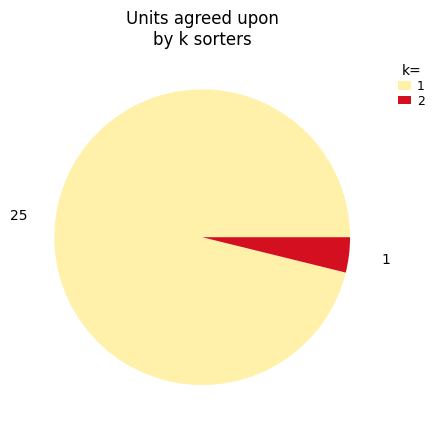

In [ ]:
multi_comp = scom.compare_multiple_sorters(
    sorting_list=unit_list,
    name_list=sorter_list,
    spiketrain_mode='union',
    verbose=True
)
w = sw.plot_multicomparison_agreement(multi_comp) # k sorters means the number of sorters
# w = sw.plot_multicomparison_agreement_by_sorter(multi_comp)
# w = sw.plot_multicomparison_graph(multi_comp)

In [ ]:
from spike_curation import calculate_analyzer_extension,spike_overview
import numpy as np

In [ ]:
analyser_list

In [ ]:
for sorting_spikes,analyser_folder_name in zip(unit_list,analyser_list):
    unit_labels = sorting_spikes.get_property("quality")
    recording_saved = get_preprocessed_recording(oe_folder,analysis_methods)
    analysis_methods.update({"load_existing_motion_info": True})
    recording_saved=si.astype(recording_saved,np.float32)
    recording_corrected_dict=motion_correction_shankbyshank(recording_saved,oe_folder,analysis_methods)
    if len(recording_corrected_dict)>1:
        recording_for_analysis=si.aggregate_channels(recording_corrected_dict)
    else:
        recording_for_analysis=recording_corrected_dict[0]
    sorting_analyzer = si.create_sorting_analyzer(
        sorting=sorting_spikes,
        recording=recording_for_analysis,
        sparse=True,  # default
        format="binary_folder",
        folder=oe_folder / analyser_folder_name,
        overwrite=True,  # default  # default
    )
    calculate_analyzer_extension(sorting_analyzer)
    metric_names = si.get_quality_metric_list()
    qm = si.compute_quality_metrics(sorting_analyzer, metric_names=metric_names, verbose=True)
    display(qm)
    _, _, _, _ = spike_overview(
        oe_folder,
        this_sorter,
        sorting_spikes,
        sorting_analyzer,
        recording_for_analysis,
        unit_labels,
    )

## Session 5: Running spike sorting with kilosort standalone

In [1]:
from kilosort.run_kilosort import run_kilosort
from pathlib import Path
import os,json
import numpy as np
import pandas as pd
from kilosort.io import load_ops,load_probe
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams

In [2]:
# outputs saved to results_dir
def load_result_kilosort(results_dir):
    ops = load_ops(results_dir / 'ops.npy')
    camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
    contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
    chan_map =  np.load(results_dir / 'channel_map.npy')
    templates =  np.load(results_dir / 'templates.npy')
    chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
    chan_best = chan_map[chan_best]
    amplitudes = np.load(results_dir / 'amplitudes.npy')
    st = np.load(results_dir / 'spike_times.npy')
    clu = np.load(results_dir / 'spike_clusters.npy')
    firing_rates = np.unique(clu, return_counts=True)[1] * ops['fs'] / st.max()
    dshift = ops['dshift']
    return ops, camps,contam_pct,chan_map,templates,chan_best,amplitudes,st,clu,firing_rates,dshift

In [3]:
def find_binary_files(base_directory, file_type):
    selected_files = []
    for root, _, files in os.walk(base_directory):
        for file in files:
            if file.lower().endswith(file_type) and '.acquisition_board' in root:
                p=Path(root)
                selected_files.append(p.joinpath(file))
    return selected_files

In [4]:
def plot_overview_kilosort(settings,dshift,chan_best,chan_map,firing_rates,camps,contam_pct,templates,st,ops,clu):
    display_in_sec=5
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False
    gray = .5 * np.ones(3)

    fig = plt.figure(figsize=(10,10), dpi=100)
    grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)
    if settings.get("nblocks")>0:
        ax = fig.add_subplot(grid[0,0])
        ax.plot(np.arange(0, ops['Nbatches'])*2, dshift)
        ax.set_xlabel('time (sec.)')
        ax.set_ylabel('drift (um)')

    ax = fig.add_subplot(grid[0,1:])
    t0 = 0
    t1 = np.nonzero(st > ops['fs']*display_in_sec)[0][0]
    ax.scatter(st[t0:t1]/ops['fs'], chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
    ax.set_xlim([0, display_in_sec])
    ax.set_ylim([chan_map.max(), 0])
    ax.set_xlabel('time (sec.)')
    ax.set_ylabel('channel')
    ax.set_title('spikes from units')

    ax = fig.add_subplot(grid[1,0])
    nb=ax.hist(firing_rates, 20, color=gray)
    ax.set_xlabel('firing rate (Hz)')
    ax.set_ylabel('# of units')

    ax = fig.add_subplot(grid[1,1])
    nb=ax.hist(camps, 20, color=gray)
    ax.set_xlabel('amplitude')
    ax.set_ylabel('# of units')

    ax = fig.add_subplot(grid[1,2])
    nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
    ax.plot([10, 10], [0, nb[0].max()], 'k--')
    ax.set_xlabel('% contamination')
    ax.set_ylabel('# of units')
    ax.set_title('< 10% = good units')

    for k in range(2):
        ax = fig.add_subplot(grid[2,k])
        is_ref = contam_pct<10.
        ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
        ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
        ax.set_ylabel('amplitude (a.u.)')
        ax.set_xlabel('firing rate (Hz)')
        ax.legend()
        if k==1:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_title('loglog')
    probe = ops['probe']
    # x and y position of probe sites
    xc, yc = probe['xc'], probe['yc']
    nc = 16 # number of channels to show
    good_units = np.nonzero(contam_pct <= 0.1)[0]
    mua_units = np.nonzero(contam_pct > 0.1)[0]

    gstr = ['good', 'mua']
    for j in range(2):
        print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('title = number of spikes from each unit')
        units = good_units if j==0 else mua_units
        fig = plt.figure(figsize=(12,3), dpi=150)
        grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

        for k in range(40):
            wi = units[np.random.randint(len(units))]
            wv = templates[wi].copy()
            cb = chan_best[wi]
            nsp = (clu==wi).sum()

            ax = fig.add_subplot(grid[k//20, k%20])
            n_chan = wv.shape[-1]
            ic0 = max(0, cb-nc//2)
            ic1 = min(n_chan, cb+nc//2)
            wv = wv[:, ic0:ic1]
            x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

            amp = 4
            for ii, (xi,yi) in enumerate(zip(x0,y0)):
                t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
                t /= wv.shape[0] / 20
                ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

            ax.set_title(f'{nsp}', fontsize='small')
            ax.axis('off')
        plt.show()

In [5]:
##specify an animal root folder to speed up the process because there are a lot of subfolders to look for
dir_list = []
thisDataset=r"Y:\GN25034"
for root, dirs, files in os.walk(thisDataset):
    for folder in dirs:
        if folder.startswith("Record"):
            dir_list.append(Path(root))

In [6]:
kilosort_setting_file = "./p2_parameters_kilosortGUI.json"
#kilosort_setting_file = "./H10_parameters_kilosortGUI_shank01.json"
probe_file='./P2_RHD2132_openEphys_mapping.prb'
#probe_file='./H10_RHD2164_openEphys_mapping.prb'
#probe_file='./H10_RHD2164_rev_openEphys_mapping.prb'
if isinstance(kilosort_setting_file, dict):
    kilosort_methods = kilosort_setting_file
else:
    with open(kilosort_setting_file, "r") as f:
        print(f"load analysis methods from file {kilosort_setting_file}")
        kilosort_methods = json.loads(f.read())
settings = {**kilosort_methods['main'], **kilosort_methods['extra']}
settings['probe_path']=probe_file

load analysis methods from file ./p2_parameters_kilosortGUI.json


In [ ]:
def batch_kilosort_process(settings,dir_list):
    file_type=".dat"
    probe_path=settings.get('probe_path')
    if settings.get("nblocks")==0.0:
        ks_folder_name='kilosort4'
    else:
        ks_folder_name='kilosort4_motion_corrected'
    for this_dir in dir_list:
        if type(this_dir)==str:
            this_dir=Path(this_dir)
        if this_dir.stem =='2025-08-03_21-24-13':
            these_bad_channels=[2,4,5,6,9]
            #these_bad_channels=[]
        elif this_dir.stem =='2025-09-08_00-40-55':
            these_bad_channels=[4,6,9]
        elif this_dir.stem =='2025-09-08_01-12-18':
            these_bad_channels=[23]
        elif this_dir.stem =='2025-09-08_00-40-55':
            these_bad_channels=[23]
        elif this_dir.stem =='2025-09-24_18-40-05':
            these_bad_channels=[2]
        else:
            these_bad_channels=[]

        selected_files=find_binary_files(this_dir, file_type)
        if len(selected_files)>1:
            print("more than one dat file is detected")
        else:
            print(selected_files)
            binary_file=selected_files[0]
        if probe_path.startswith("./H10_RHD2164"):
            shank_of_interest=0
        elif probe_path.startswith("./P2_RHD2132"):
            shank_of_interest=0
        else:
            shank_of_interest=None        
        results_dir = this_dir / ks_folder_name
        print(f"analysing {this_dir}")
        ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes=run_kilosort(settings=settings,filename=binary_file,results_dir=results_dir,bad_channels=these_bad_channels,shank_idx=shank_of_interest)
        if shank_of_interest==None:
            pass
        else:
            results_dir = this_dir / results_dir / f'shank_{shank_of_interest}'
        #_, camps,contam_pct,chan_map,templates,chan_best,amplitudes,_,_,firing_rates,dshift=load_result_kilosort(results_dir)
        #plot_overview_kilosort(settings,dshift,chan_best,chan_map,firing_rates,camps,contam_pct,templates,st,ops,clu)

In [17]:
settings.update({'batch_size':180000})

In [ ]:
batch_kilosort_process(settings,dir_list[3:4])